# MVR Website Prototype

Simple deterministic test case: Sales (6 levels) + Engineering (4 levels) + CEO

## Pipeline:
1. Create test data
2. Build directed graph H
3. MVR with pure random swap (adjustable R, T)
4. Visualize MVR results
5. K-means clustering (4 methods available)
6. Visualize K-means results

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from collections import defaultdict
from math import comb
import warnings
warnings.filterwarnings('ignore')
print('Imports successful')

Imports successful


## Step 1: Create Test Data

10 workers in Sales (Sales1-6 -> CEO)  
10 workers in Engineering (Eng1-4 -> CEO)

In [2]:
def create_test_data():
    """
    Create clean deterministic test data:
    - 10 workers follow: Sales1->Sales2->Sales3->Sales4->Sales5->Sales6->CEO
    - 10 workers follow: Eng1->Eng2->Eng3->Eng4->CEO
    """
    data = []
    worker_id = 1
    
    # Sales workers
    sales_path = ['Sales1', 'Sales2', 'Sales3', 'Sales4', 'Sales5', 'Sales6', 'CEO']
    for _ in range(10):
        for year, role in enumerate(sales_path, start=2010):
            data.append({
                'Worker': worker_id,
                'Year': year,
                'Role': role
            })
        worker_id += 1
    
    # Engineering workers
    eng_path = ['Eng1', 'Eng2', 'Eng3', 'Eng4', 'CEO']
    for _ in range(10):
        for year, role in enumerate(eng_path, start=2010):
            data.append({
                'Worker': worker_id,
                'Year': year,
                'Role': role
            })
        worker_id += 1
    
    return pd.DataFrame(data)

panel_df = create_test_data()
print(f"Created test data: {panel_df['Worker'].nunique()} workers, {panel_df['Role'].nunique()} roles")
print(f"Roles: {sorted(panel_df['Role'].unique())}")
panel_df.head(15)

Created test data: 20 workers, 11 roles
Roles: ['CEO', 'Eng1', 'Eng2', 'Eng3', 'Eng4', 'Sales1', 'Sales2', 'Sales3', 'Sales4', 'Sales5', 'Sales6']


,Worker,Year,Role
0,1,2010,Sales1
1,1,2011,Sales2
2,1,2012,Sales3
3,1,2013,Sales4
4,1,2014,Sales5
5,1,2015,Sales6
6,1,2016,CEO
7,2,2010,Sales1
8,2,2011,Sales2
9,2,2012,Sales3


## Step 2: Build Directed Graph H (ALL PAIRS Method)

In [3]:
def build_directed_graph_all_pairs(panel_df):
    """
    Build directed graph H using ALL PAIRS method.
    For each worker's career path A->B->C, create edges: A->B, B->C, AND A->C
    """
    H = nx.DiGraph()
    
    for worker, group in panel_df.groupby('Worker'):
        path = group.sort_values('Year')['Role'].tolist()
        
        # Create ALL PAIRS edges
        for i in range(len(path)):
            for j in range(i + 1, len(path)):
                if H.has_edge(path[i], path[j]):
                    H[path[i]][path[j]]['weight'] += 1
                else:
                    H.add_edge(path[i], path[j], weight=1)
    
    return H

H = build_directed_graph_all_pairs(panel_df)

print(f"Graph H:")
print(f"  Nodes: {H.number_of_nodes()}")
print(f"  Edges: {H.number_of_edges()}")
print(f"Out-degrees:")
for node in sorted(H.nodes(), key=lambda x: H.out_degree(x, weight='weight'), reverse=True):
    print(f"  {node:10s}: {H.out_degree(node, weight='weight')}")

Graph H:
  Nodes: 11
  Edges: 31
Out-degrees:
  Sales1    : 60
  Sales2    : 50
  Sales3    : 40
  Eng1      : 40
  Sales4    : 30
  Eng2      : 30
  Sales5    : 20
  Eng3      : 20
  Sales6    : 10
  Eng4      : 10
  CEO       : 0


## Step 3: MVR with Pure Random Swap

### User-adjustable parameters:

In [4]:
# === USER PARAMETERS ===
R = 3000           # Number of repetitions
T = 1500           # Iterations per repetition
EARLY_STOP = True # Enable early stopping
# =======================

In [5]:
def compute_violations_fast(H, ranking):
    """Count violations efficiently."""
    rank_dict = {job: i for i, job in enumerate(ranking)}
    violations = sum(
        H[u][v]['weight']
        for u, v in H.edges()
        if rank_dict[u] > rank_dict[v]
    )
    return violations

def find_optimal_rankings_mvr(H, R=3000, T=1500, convergence_window=500, early_stop=False, seed=42):
    """
    Paper's MVR: pure random swap with S' <= S acceptance.
    """
    random.seed(seed)
    np.random.seed(seed)
    
    jobs = list(H.nodes())
    n = len(jobs)
    
    # Initial ranking by out-degree
    jobs.sort(key=lambda x: H.out_degree(x, weight='weight'), reverse=True)
    current_ranking = jobs.copy()
    current_violations = compute_violations_fast(H, current_ranking)
    
    min_violations = current_violations
    optimal_rankings = set()
    optimal_rankings.add(tuple(current_ranking))
    
    progress = []
    
    for r in range(R):
        for t in range(T):
            # Pure random swap
            i, j = random.sample(range(n), 2)
            new_ranking = current_ranking.copy()
            new_ranking[i], new_ranking[j] = new_ranking[j], new_ranking[i]
            new_violations = compute_violations_fast(H, new_ranking)
            
            # Accept if S' <= S (paper's acceptance rule)
            if new_violations <= current_violations:
                current_ranking = new_ranking
                current_violations = new_violations
                
                if new_violations < min_violations:
                    min_violations = new_violations
                    optimal_rankings.clear()
                    optimal_rankings.add(tuple(current_ranking))
                elif new_violations == min_violations:
                    optimal_rankings.add(tuple(current_ranking))
        
        progress.append(len(optimal_rankings))
        
        # Early stopping
        if early_stop and r >= convergence_window:
            recent = progress[-convergence_window:]
            if len(set(recent)) == 1:
                print(f"Early stopping at R={r+1} (no new rankings for {convergence_window} rounds)")
                break
    
    return list(optimal_rankings), min_violations, progress

optimal_rankings, min_violations, progress = find_optimal_rankings_mvr(
    H, R=R, T=T, early_stop=EARLY_STOP
)

print(f"{'='*80}")
print(f"MVR RESULTS")
print(f"{'='*80}")
print(f"Found {len(optimal_rankings)} unique optimal rankings")
print(f"Minimum violations: {min_violations}")
print(f"First ranking: {optimal_rankings[0]}")

Early stopping at R=557 (no new rankings for 500 rounds)
MVR RESULTS
Found 210 unique optimal rankings
Minimum violations: 0
First ranking: ('Sales1', 'Sales2', 'Sales3', 'Eng1', 'Eng2', 'Sales4', 'Sales5', 'Eng3', 'Sales6', 'Eng4', 'CEO')


## Step 4: Visualize MVR Results

### 4.1 Convergence Plot

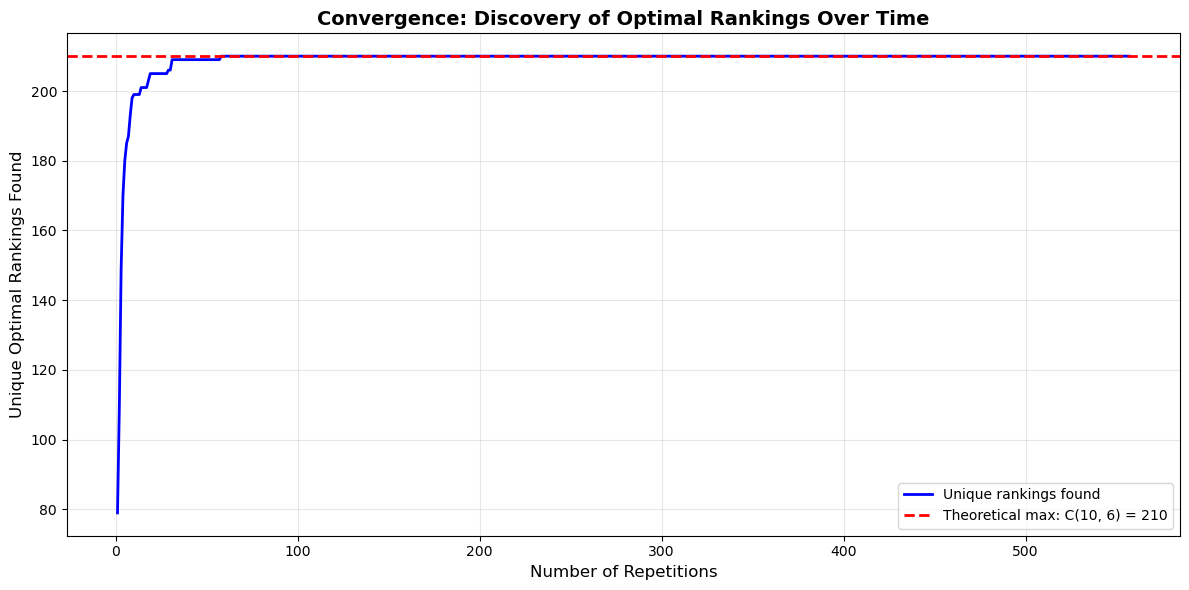


Coverage: 210/210 = 100.0%
Growth rate analysis: Converged


In [6]:
n_sales = len([j for j in H.nodes() if 'Sales' in j])
n_eng = len([j for j in H.nodes() if 'Eng' in j])
theoretical_max = comb(n_sales + n_eng, n_sales)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(progress) + 1), progress, 'b-', linewidth=2, label='Unique rankings found')
plt.axhline(y=theoretical_max, color='r', linestyle='--', linewidth=2, 
            label=f'Theoretical max: C({n_sales + n_eng}, {n_sales}) = {theoretical_max}')
plt.xlabel('Number of Repetitions', fontsize=12)
plt.ylabel('Unique Optimal Rankings Found', fontsize=12)
plt.title('Convergence: Discovery of Optimal Rankings Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

coverage = len(optimal_rankings) / theoretical_max * 100
print(f"\nCoverage: {len(optimal_rankings)}/{theoretical_max} = {coverage:.1f}%")
print(f"Growth rate analysis: {'Converged' if len(progress) > 1 and progress[-1] == progress[-2] else 'Still growing'}")

### 4.2 Job Position Variance Analysis

In [7]:
# Compute statistics
positions = defaultdict(list)
for ranking in optimal_rankings:
    for pos, job in enumerate(ranking):
        positions[job].append(pos)

stats = {}
for job, pos_list in positions.items():
    stats[job] = {
        'mean': np.mean(pos_list),
        'std': np.std(pos_list, ddof=1) if len(pos_list) > 1 else 0,
        'var': np.var(pos_list, ddof=1) if len(pos_list) > 1 else 0,
        'min': min(pos_list),
        'max': max(pos_list),
        'unique': len(set(pos_list))
    }

stats_df = pd.DataFrame(stats).T
stats_df = stats_df.sort_values('mean')
stats_df.index.name = 'Job'
print("Job Position Statistics:")
print(stats_df.to_string())

Job Position Statistics:
             mean       std       var   min   max  unique
Job                                                      
Sales1   0.571429  0.822613  0.676692   0.0   4.0     5.0
Eng1     1.200000  1.329820  1.768421   0.0   6.0     7.0
Sales2   2.142857  1.061988  1.127820   1.0   5.0     5.0
Eng2     3.400000  1.628690  2.652632   1.0   7.0     7.0
Sales3   3.714286  1.163350  1.353383   2.0   6.0     5.0
Sales4   5.285714  1.163350  1.353383   3.0   7.0     5.0
Eng3     5.600000  1.628690  2.652632   2.0   8.0     7.0
Sales5   6.857143  1.061988  1.127820   4.0   8.0     5.0
Eng4     7.800000  1.329820  1.768421   3.0   9.0     7.0
Sales6   8.428571  0.822613  0.676692   5.0   9.0     5.0
CEO     10.000000  0.000000  0.000000  10.0  10.0     1.0


### 4.3 Visualize Variance & Average Ranking

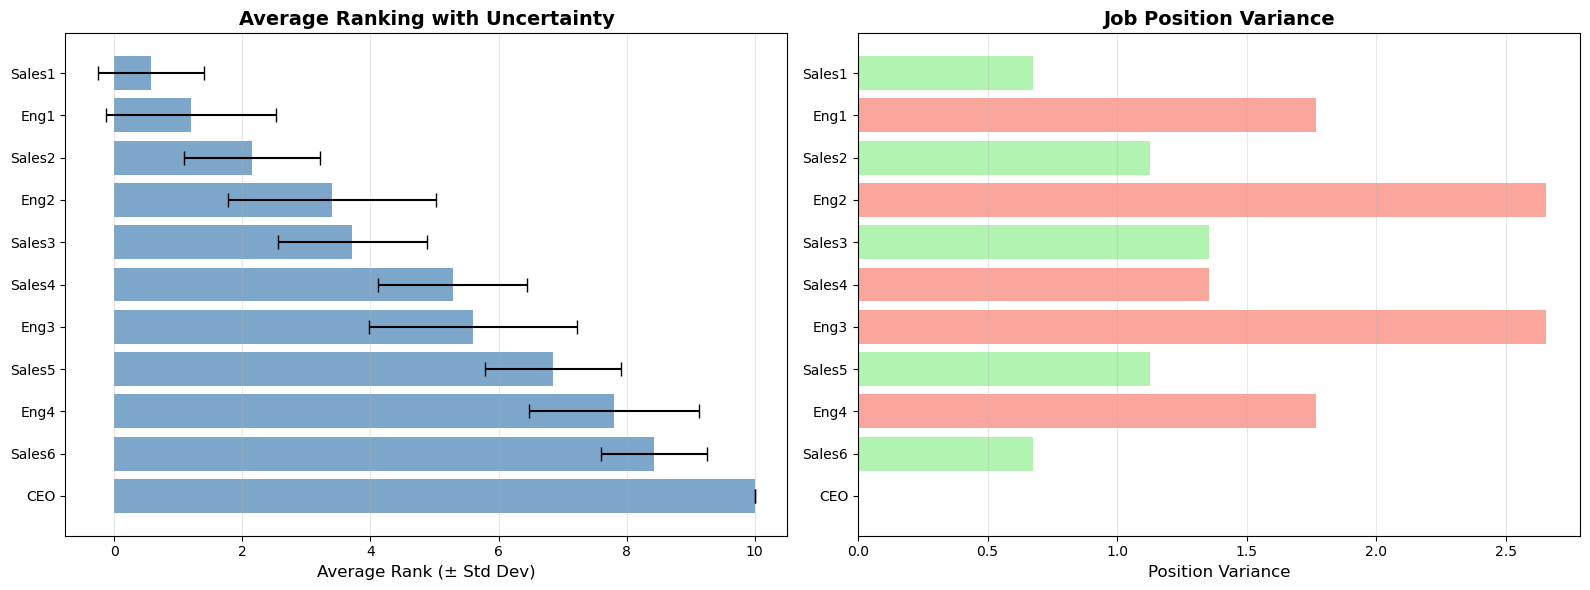

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Mean rank with error bars
jobs_sorted = stats_df.index.tolist()
means = [stats[j]['mean'] for j in jobs_sorted]
stds = [stats[j]['std'] for j in jobs_sorted]

ax1.barh(range(len(jobs_sorted)), means, xerr=stds, capsize=5, alpha=0.7, color='steelblue')
ax1.set_yticks(range(len(jobs_sorted)))
ax1.set_yticklabels(jobs_sorted)
ax1.set_xlabel('Average Rank (± Std Dev)', fontsize=12)
ax1.set_title('Average Ranking with Uncertainty', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Variance by job
variances = [stats[j]['var'] for j in jobs_sorted]
colors = ['salmon' if v > np.median(variances) else 'lightgreen' for v in variances]

ax2.barh(range(len(jobs_sorted)), variances, alpha=0.7, color=colors)
ax2.set_yticks(range(len(jobs_sorted)))
ax2.set_yticklabels(jobs_sorted)
ax2.set_xlabel('Position Variance', fontsize=12)
ax2.set_title('Job Position Variance', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 5: K-means Clustering (4 Methods)

### 5.1 Method 1: Bonhomme et al. (2019) - Rank Std

In [9]:
def method_bonhomme(optimal_rankings):
    """
    Paper's method: threshold = (1/(N-1)) * sum(Var(r_v)) * N
    This is the RANK STD method.
    """
    positions = defaultdict(list)
    for ranking in optimal_rankings:
        for pos, job in enumerate(ranking):
            positions[job].append(pos)
    
    jobs = sorted(positions.keys(), key=lambda x: np.mean(positions[x]))
    job_mean_ranks = np.array([np.mean(positions[j]) for j in jobs]).reshape(-1, 1)
    N = len(jobs)
    
    # sum of variances across jobs
    sum_var = sum(np.var(positions[j], ddof=1) if len(positions[j]) > 1 else 0 for j in jobs)
    threshold = (1 / (N - 1)) * sum_var * N
    
    optimal_K = 1
    Q_values = []
    
    for K in range(1, N + 1):
        if K == N:
            Q_K = 0.0
        else:
            kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
            kmeans.fit(job_mean_ranks)
            Q_K = kmeans.inertia_
        
        Q_values.append(Q_K)
        
        if Q_K <= threshold:
            optimal_K = K
            break
    
    if optimal_K == N:
        labels = np.arange(N)
    else:
        kmeans = KMeans(n_clusters=optimal_K, random_state=0, n_init=10)
        labels = kmeans.fit_predict(job_mean_ranks)
    
    return {
        'K': optimal_K,
        'threshold': threshold,
        'Q_values': Q_values,
        'labels': labels,
        'jobs': jobs,
        'mean_ranks': job_mean_ranks
    }

result_bonhomme = method_bonhomme(optimal_rankings)
print(f"Bonhomme et al. (2019) - Rank Std:")
print(f"  Optimal K: {result_bonhomme['K']}")
print(f"  Threshold: {result_bonhomme['threshold']:.4f}")

Bonhomme et al. (2019) - Rank Std:
  Optimal K: 3
  Threshold: 16.6737


### 5.2 Method 2: Overall Std Threshold

In [10]:
def method_overall_std(optimal_rankings):
    """
    Overall std: threshold = (1/(N-1)) * rank_var * N
    rank_var = variance of average ranks across jobs
    """
    positions = defaultdict(list)
    for ranking in optimal_rankings:
        for pos, job in enumerate(ranking):
            positions[job].append(pos)
    
    jobs = sorted(positions.keys(), key=lambda x: np.mean(positions[x]))
    job_mean_ranks = np.array([np.mean(positions[j]) for j in jobs]).reshape(-1, 1)
    N = len(jobs)
    
    # variance of average ranks
    average_ranks = {job: np.mean(positions[job]) for job in jobs}
    rank_var = np.var(list(average_ranks.values()))
    threshold = (1 / (N - 1)) * rank_var * N
    
    optimal_K = 1
    Q_values = []
    
    for K in range(1, N + 1):
        if K == N:
            Q_K = 0.0
        else:
            kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
            kmeans.fit(job_mean_ranks)
            Q_K = kmeans.inertia_
        
        Q_values.append(Q_K)
        
        if Q_K <= threshold:
            optimal_K = K
            break
    
    if optimal_K == N:
        labels = np.arange(N)
    else:
        kmeans = KMeans(n_clusters=optimal_K, random_state=0, n_init=10)
        labels = kmeans.fit_predict(job_mean_ranks)
    
    return {
        'K': optimal_K,
        'threshold': threshold,
        'Q_values': Q_values,
        'labels': labels,
        'jobs': jobs,
        'mean_ranks': job_mean_ranks
    }

result_overall = method_overall_std(optimal_rankings)
print(f"Overall Std Threshold:")
print(f"  Optimal K: {result_overall['K']}")
print(f"  Threshold: {result_overall['threshold']:.4f}")

Overall Std Threshold:
  Optimal K: 4
  Threshold: 9.4914


### 5.3 Method 3: Elbow Method

**Note**: This method plots the inertia curve first. You can visually inspect and manually select K.

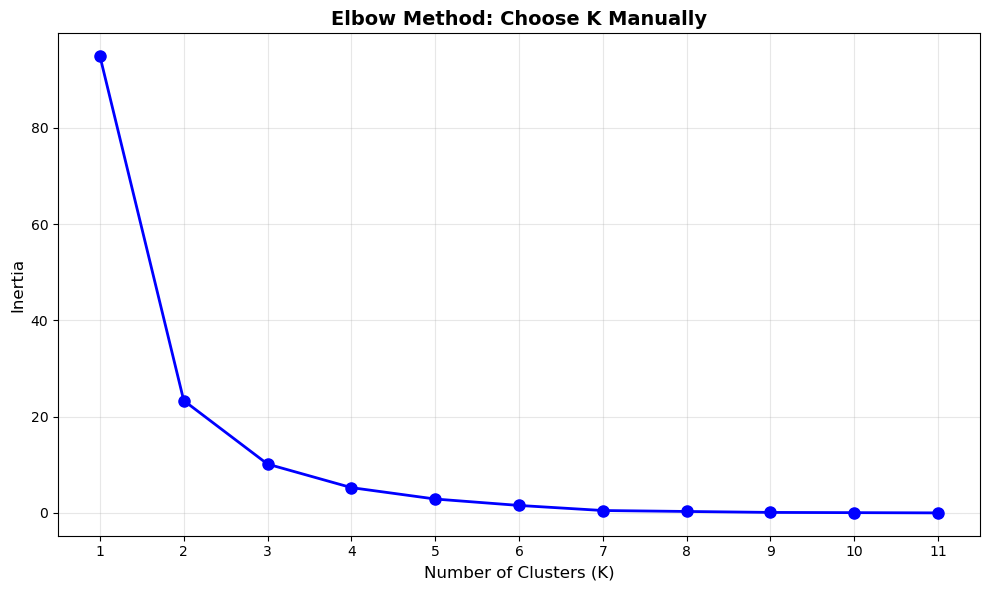

Please visually inspect the curve above and choose optimal K.
Looking at the plot, K=4 seems reasonable based on where the curve flattens.

Elbow Method (Manual Selection):
  Chosen K: 4


In [11]:
def method_elbow_plot(optimal_rankings):
    """
    Elbow method: Plot inertia curve for visual inspection.
    User can manually select K based on the plot.
    """
    positions = defaultdict(list)
    for ranking in optimal_rankings:
        for pos, job in enumerate(ranking):
            positions[job].append(pos)
    
    jobs = sorted(positions.keys(), key=lambda x: np.mean(positions[x]))
    job_mean_ranks = np.array([np.mean(positions[j]) for j in jobs]).reshape(-1, 1)
    N = len(jobs)
    
    # Compute inertia for K=1 to N
    inertias = []
    K_range = range(1, N + 1)
    for K in K_range:
        if K == 1:
            inertias.append(np.var(job_mean_ranks) * N)
        elif K == N:
            inertias.append(0.0)
        else:
            kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
            kmeans.fit(job_mean_ranks)
            inertias.append(kmeans.inertia_)
    
    # Plot for visual inspection
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (K)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.title('Elbow Method: Choose K Manually', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(list(K_range))
    plt.tight_layout()
    plt.show()
    
    return {
        'inertias': inertias,
        'jobs': jobs,
        'mean_ranks': job_mean_ranks,
        'K_range': list(K_range)
    }

# Plot the elbow curve
elbow_data = method_elbow_plot(optimal_rankings)
print("Please visually inspect the curve above and choose optimal K.")
print("Looking at the plot, K=4 seems reasonable based on where the curve flattens.")

# Now create a function to apply chosen K
def apply_elbow_K(elbow_data, chosen_K):
    """
    Apply the manually chosen K to create clusters.
    """
    jobs = elbow_data['jobs']
    mean_ranks = elbow_data['mean_ranks']
    N = len(jobs)
    
    if chosen_K == N:
        labels = np.arange(N)
    else:
        kmeans = KMeans(n_clusters=chosen_K, random_state=0, n_init=10)
        labels = kmeans.fit_predict(mean_ranks)
    
    return {
        'K': chosen_K,
        'inertias': elbow_data['inertias'],
        'labels': labels,
        'jobs': jobs,
        'mean_ranks': mean_ranks
    }

# Apply K=4 as suggested
CHOSEN_K = 4  # User can change this based on visual inspection
result_elbow = apply_elbow_K(elbow_data, CHOSEN_K)
print(f"\nElbow Method (Manual Selection):")
print(f"  Chosen K: {result_elbow['K']}")

### 5.4 Method 4: Simple Variance Threshold

In [12]:
def method_simple_var(optimal_rankings):
    """
    Simple: Use median job variance as threshold
    """
    positions = defaultdict(list)
    for ranking in optimal_rankings:
        for pos, job in enumerate(ranking):
            positions[job].append(pos)
    
    jobs = sorted(positions.keys(), key=lambda x: np.mean(positions[x]))
    job_mean_ranks = np.array([np.mean(positions[j]) for j in jobs]).reshape(-1, 1)
    N = len(jobs)
    
    # median job variance
    job_variances = [np.var(positions[j], ddof=1) if len(positions[j]) > 1 else 0 for j in jobs]
    threshold = np.median(job_variances)
    
    optimal_K = 1
    Q_values = []
    
    for K in range(1, N + 1):
        if K == N:
            Q_K = 0.0
        else:
            kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
            kmeans.fit(job_mean_ranks)
            Q_K = kmeans.inertia_ / N  # Average variance per job
        
        Q_values.append(Q_K)
        
        if Q_K <= threshold:
            optimal_K = K
            break
    
    if optimal_K == N:
        labels = np.arange(N)
    else:
        kmeans = KMeans(n_clusters=optimal_K, random_state=0, n_init=10)
        labels = kmeans.fit_predict(job_mean_ranks)
    
    return {
        'K': optimal_K,
        'threshold': threshold,
        'Q_values': Q_values,
        'labels': labels,
        'jobs': jobs,
        'mean_ranks': job_mean_ranks
    }

result_simple = method_simple_var(optimal_rankings)
print(f"Simple Variance Threshold:")
print(f"  Optimal K: {result_simple['K']}")
print(f"  Threshold: {result_simple['threshold']:.4f}")

Simple Variance Threshold:
  Optimal K: 3
  Threshold: 1.3534


## Step 6: Visualize K-means Results

### 6.1 Compare All Methods

In [13]:
print(f"{'='*80}")
print(f"K-MEANS COMPARISON")
print(f"{'='*80}")
print(f"1. Bonhomme et al. (2019) - Rank Std:")
print(f"   Optimal K: {result_bonhomme['K']}")
print(f"   Threshold: {result_bonhomme['threshold']:.4f}")
print(f"")
print(f"2. Overall Std Threshold:")
print(f"   Optimal K: {result_overall['K']}")
print(f"   Threshold: {result_overall['threshold']:.4f}")
print(f"")
print(f"3. Elbow Method (Manual Selection):")
print(f"   Chosen K: {result_elbow['K']} (manually selected)")
print(f"")
print(f"4. Simple Variance Threshold:")
print(f"   Optimal K: {result_simple['K']}")
print(f"   Threshold: {result_simple['threshold']:.4f}")

K-MEANS COMPARISON
1. Bonhomme et al. (2019) - Rank Std:
   Optimal K: 3
   Threshold: 16.6737

2. Overall Std Threshold:
   Optimal K: 4
   Threshold: 9.4914

3. Elbow Method (Manual Selection):
   Chosen K: 4 (manually selected)

4. Simple Variance Threshold:
   Optimal K: 3
   Threshold: 1.3534


### 6.2 Visualize Inertia/Q(K) Curves

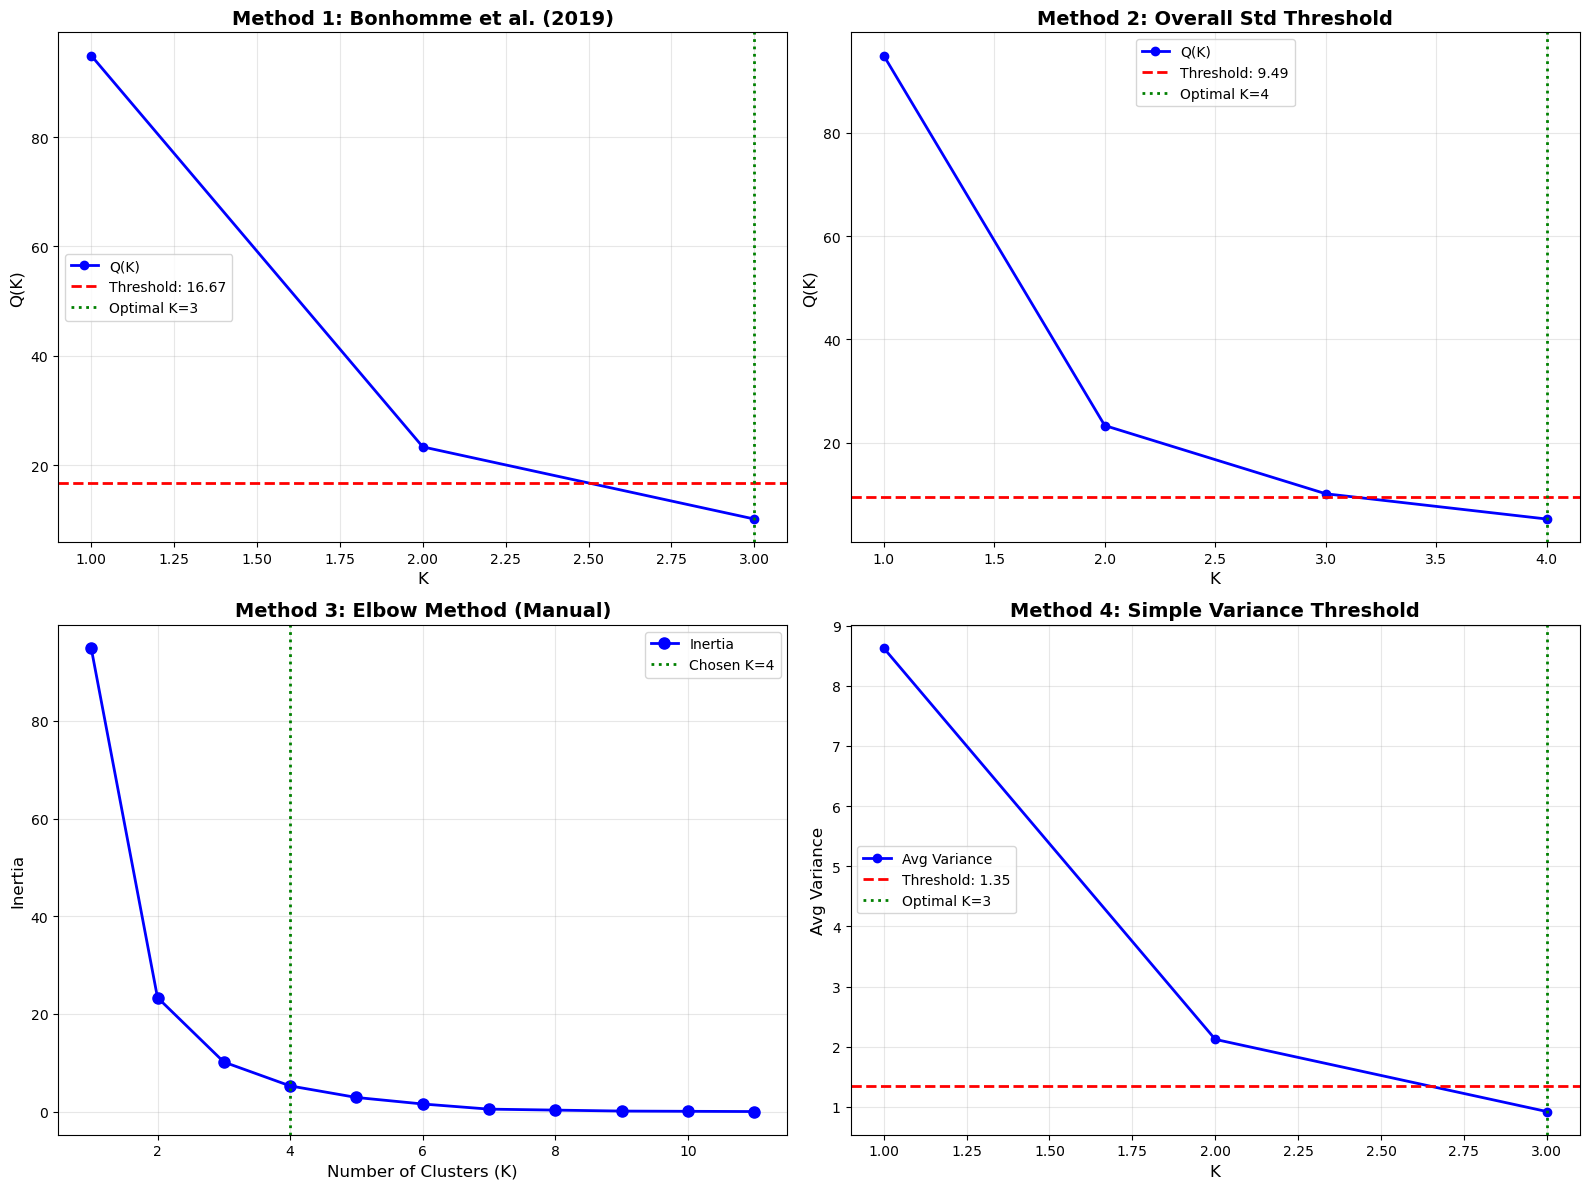

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Method 1: Bonhomme
ax = axes[0, 0]
K_range = range(1, len(result_bonhomme['Q_values']) + 1)
ax.plot(K_range, result_bonhomme['Q_values'], 'bo-', linewidth=2, label='Q(K)')
ax.axhline(y=result_bonhomme['threshold'], color='r', linestyle='--', linewidth=2, 
           label=f"Threshold: {result_bonhomme['threshold']:.2f}")
ax.axvline(x=result_bonhomme['K'], color='g', linestyle=':', linewidth=2, 
           label=f"Optimal K={result_bonhomme['K']}")
ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Q(K)', fontsize=12)
ax.set_title('Method 1: Bonhomme et al. (2019)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Method 2: Overall Std
ax = axes[0, 1]
K_range = range(1, len(result_overall['Q_values']) + 1)
ax.plot(K_range, result_overall['Q_values'], 'bo-', linewidth=2, label='Q(K)')
ax.axhline(y=result_overall['threshold'], color='r', linestyle='--', linewidth=2, 
           label=f"Threshold: {result_overall['threshold']:.2f}")
ax.axvline(x=result_overall['K'], color='g', linestyle=':', linewidth=2, 
           label=f"Optimal K={result_overall['K']}")
ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Q(K)', fontsize=12)
ax.set_title('Method 2: Overall Std Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Method 3: Elbow (manual selection)
ax = axes[1, 0]
K_range = result_elbow['K_range'] if 'K_range' in result_elbow else range(1, len(result_elbow['inertias']) + 1)
ax.plot(K_range, result_elbow['inertias'], 'bo-', linewidth=2, markersize=8, label='Inertia')
ax.axvline(x=result_elbow['K'], color='g', linestyle=':', linewidth=2, 
           label=f"Chosen K={result_elbow['K']}")
ax.set_xlabel('Number of Clusters (K)', fontsize=12)
ax.set_ylabel('Inertia', fontsize=12)
ax.set_title('Method 3: Elbow Method (Manual)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Method 4: Simple Variance
ax = axes[1, 1]
K_range = range(1, len(result_simple['Q_values']) + 1)
ax.plot(K_range, result_simple['Q_values'], 'bo-', linewidth=2, label='Avg Variance')
ax.axhline(y=result_simple['threshold'], color='r', linestyle='--', linewidth=2, 
           label=f"Threshold: {result_simple['threshold']:.2f}")
ax.axvline(x=result_simple['K'], color='g', linestyle=':', linewidth=2, 
           label=f"Optimal K={result_simple['K']}")
ax.set_xlabel('K', fontsize=12)
ax.set_ylabel('Avg Variance', fontsize=12)
ax.set_title('Method 4: Simple Variance Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.3 Visualize Job Clusters (Scatter Plots)

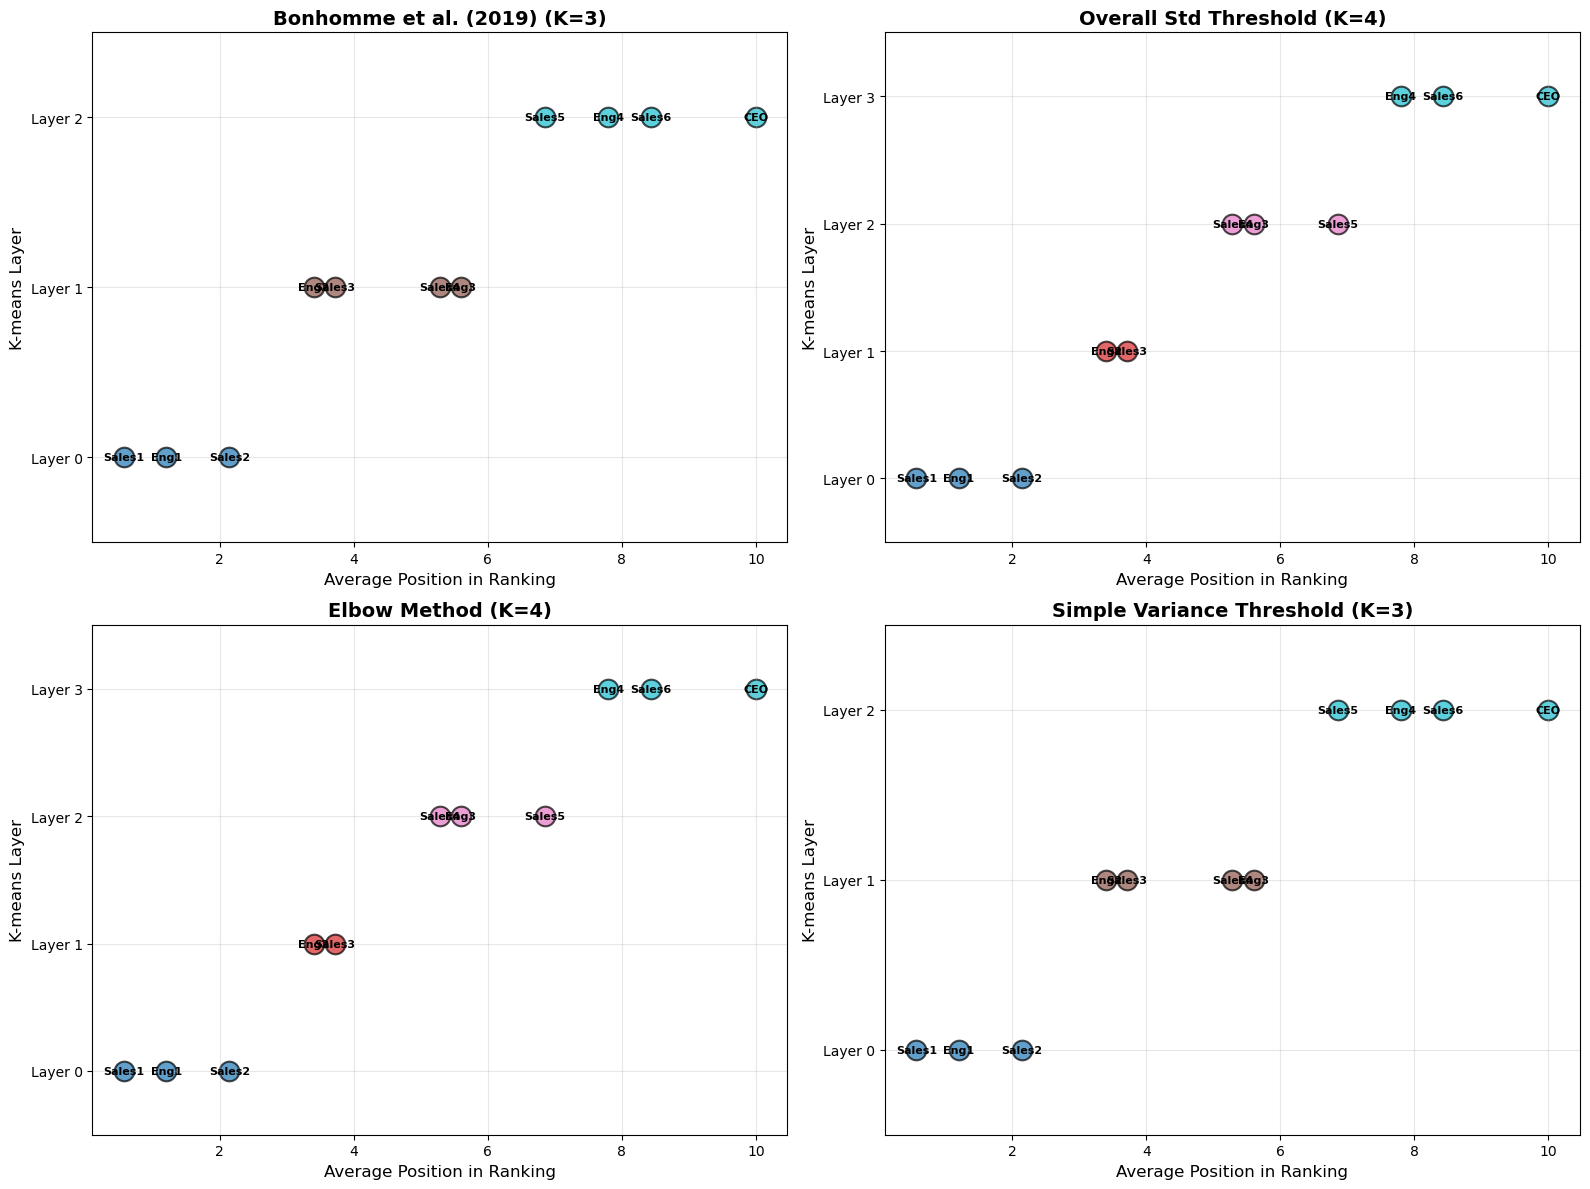

In [15]:
results = [
    (result_bonhomme, 'Bonhomme et al. (2019)'),
    (result_overall, 'Overall Std Threshold'),
    (result_elbow, 'Elbow Method'),
    (result_simple, 'Simple Variance Threshold')
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (result, method_name) in enumerate(results):
    ax = axes[idx // 2, idx % 2]
    
    jobs = result['jobs']
    labels = result['labels']
    K = result['K']
    mean_ranks = result['mean_ranks'].flatten()
    
    # Sort clusters by center position
    cluster_centers = []
    for k in range(K):
        cluster_jobs_idx = [i for i in range(len(jobs)) if labels[i] == k]
        cluster_center = np.mean([mean_ranks[i] for i in cluster_jobs_idx])
        cluster_centers.append((k, cluster_center))
    cluster_centers.sort(key=lambda x: x[1])
    cluster_order = [k for k, _ in cluster_centers]
    layer_mapping = {old_k: new_k for new_k, old_k in enumerate(cluster_order)}
    
    # Create scatter plot
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    
    for layer_id in range(K):
        jobs_in_layer = [jobs[i] for i in range(len(jobs)) if layer_mapping[labels[i]] == layer_id]
        x_vals = [mean_ranks[jobs.index(j)] for j in jobs_in_layer]
        y_vals = [layer_id] * len(jobs_in_layer)
        
        ax.scatter(x_vals, y_vals, s=200, alpha=0.7, color=colors[layer_id], 
                  edgecolors='black', linewidths=1.5, label=f'Layer {layer_id}')
        
        # Add job labels
        for j, x in zip(jobs_in_layer, x_vals):
            ax.text(x, layer_id, j, ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax.set_xlabel('Average Position in Ranking', fontsize=12)
    ax.set_ylabel('K-means Layer', fontsize=12)
    ax.set_title(f'{method_name} (K={K})', fontsize=14, fontweight='bold')
    ax.set_yticks(range(K))
    ax.set_yticklabels([f'Layer {i}' for i in range(K)])
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.5, K - 0.5)

plt.tight_layout()
plt.show()

### 6.4 Detailed Layer Assignments

In [16]:
def print_layer_assignments(result, method_name):
    """Print detailed layer assignments"""
    jobs = result['jobs']
    labels = result['labels']
    K = result['K']
    mean_ranks = result['mean_ranks'].flatten()
    
    # Sort clusters by center
    cluster_centers = []
    for k in range(K):
        cluster_jobs_idx = [i for i in range(len(jobs)) if labels[i] == k]
        cluster_center = np.mean([mean_ranks[i] for i in cluster_jobs_idx])
        cluster_centers.append((k, cluster_center))
    cluster_centers.sort(key=lambda x: x[1])
    cluster_order = [k for k, _ in cluster_centers]
    layer_mapping = {old_k: new_k for new_k, old_k in enumerate(cluster_order)}
    
    print(f"{method_name}:")
    print(f"{'='*60}")
    for layer_id in range(K):
        jobs_in_layer = [jobs[i] for i in range(len(jobs)) if layer_mapping[labels[i]] == layer_id]
        jobs_with_ranks = [(j, mean_ranks[jobs.index(j)]) for j in jobs_in_layer]
        jobs_with_ranks.sort(key=lambda x: x[1])
        
        center = cluster_centers[layer_id][1]
        print(f"Layer {layer_id} (center: {center:.2f}):")
        for job, rank in jobs_with_ranks:
            dept = 'Sales' if 'Sales' in job else ('Eng' if 'Eng' in job else 'CEO')
            print(f"  {job:<15} (rank: {rank:5.2f}, dept: {dept})")
        print()

# Print all methods
for result, method_name in results:
    print_layer_assignments(result, method_name)

Bonhomme et al. (2019):
Layer 0 (center: 1.30):
  Sales1          (rank:  0.57, dept: Sales)
  Eng1            (rank:  1.20, dept: Eng)
  Sales2          (rank:  2.14, dept: Sales)

Layer 1 (center: 4.50):
  Eng2            (rank:  3.40, dept: Eng)
  Sales3          (rank:  3.71, dept: Sales)
  Sales4          (rank:  5.29, dept: Sales)
  Eng3            (rank:  5.60, dept: Eng)

Layer 2 (center: 8.27):
  Sales5          (rank:  6.86, dept: Sales)
  Eng4            (rank:  7.80, dept: Eng)
  Sales6          (rank:  8.43, dept: Sales)
  CEO             (rank: 10.00, dept: CEO)

Overall Std Threshold:
Layer 0 (center: 1.30):
  Sales1          (rank:  0.57, dept: Sales)
  Eng1            (rank:  1.20, dept: Eng)
  Sales2          (rank:  2.14, dept: Sales)

Layer 1 (center: 3.56):
  Eng2            (rank:  3.40, dept: Eng)
  Sales3          (rank:  3.71, dept: Sales)

Layer 2 (center: 5.91):
  Sales4          (rank:  5.29, dept: Sales)
  Eng3            (rank:  5.60, dept: Eng)
  Sales5  

## Summary

This prototype demonstrates:

1. **MVR algorithm** with adjustable R and T parameters
2. **Convergence tracking** and optional early stopping
3. **Comprehensive visualizations** of job variance and rankings
4. **Four K-means methods** for hierarchy determination:
   - Bonhomme et al. (2019) - Rank Std Threshold
   - Overall Std Threshold
   - Elbow Method
   - Simple Variance Threshold
5. **Comparative analysis** with curves and scatter plots

### Key Parameters:
- `R`: Number of repetitions (default: 3000)
- `T`: Iterations per repetition (default: 1500)
- `EARLY_STOP`: Enable early stopping (default: False)

### Website Implementation:
This notebook can be converted to a Streamlit app with:
- Sliders for R and T
- Dropdown for K-means method selection
- Interactive plots
- Real-time updates